## Convolutional Autoencoder with Fashion MNIST dataset

**Imports**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

**Prepare the Dataset**

In [3]:
def map_image(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  return image, image

In [4]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

(train_dataset, test_dataset), info = tfds.load('fashion_mnist', as_supervised=True, split=["train", "test"], with_info=True)

train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

In [5]:
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    =

**Define the Model**

In [6]:
def encoder(inputs):
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2

In [7]:
def bottle_neck(inputs):
  bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)

  return bottle_neck, encoder_visualization

In [8]:
def decoder(inputs):
  conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

  return conv_3

In [9]:
def convolutional_auto_encoder():
  inputs = tf.keras.layers.Input(shape=(28, 28, 1,))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)

  model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
  return model, encoder_model


In [10]:
tf.keras.backend.clear_session()

convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295168

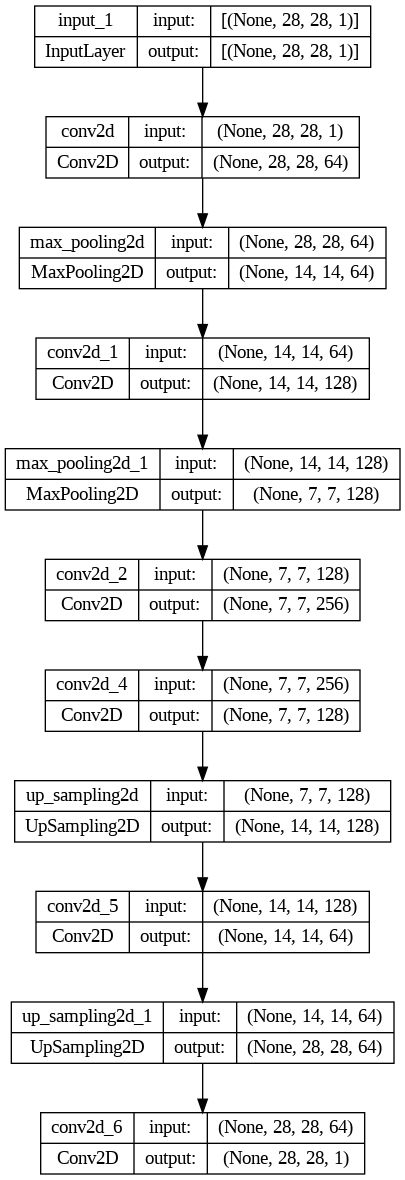

In [12]:
tf.keras.utils.plot_model(convolutional_model, show_shapes=True, show_layer_names=True)

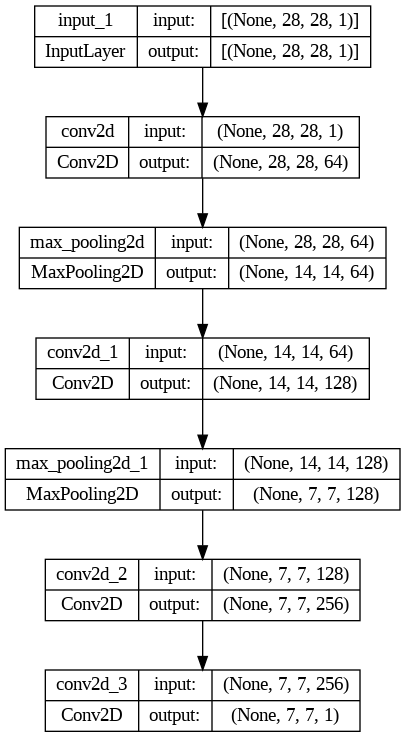

In [13]:
tf.keras.utils.plot_model(convolutional_encoder_model, show_shapes=True, show_layer_names=True)

**Compile and Train the model**

In [14]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=40)

Epoch 1/40
468/468 [==============================] - 21s 31ms/step - loss: 0.2901 - val_loss: 0.2670
Epoch 2/40
468/468 [==============================] - 14s 27ms/step - loss: 0.2618 - val_loss: 0.2605
Epoch 3/40
468/468 [==============================] - 10s 22ms/step - loss: 0.2568 - val_loss: 0.2581
Epoch 4/40
468/468 [==============================] - 11s 23ms/step - loss: 0.2543 - val_loss: 0.2549
Epoch 5/40
468/468 [==============================] - 11s 23ms/step - loss: 0.2523 - val_loss: 0.2535
Epoch 6/40
468/468 [==============================] - 10s 22ms/step - loss: 0.2511 - val_loss: 0.2526
Epoch 7/40
468/468 [==============================] - 12s 26ms/step - loss: 0.2503 - val_loss: 0.2518
Epoch 8/40
468/468 [==============================] - 12s 26ms/step - loss: 0.2495 - val_loss: 0.2512
Epoch 9/40
468/468 [==============================] - 10s 21ms/step - loss: 0.2490 - val_loss: 0.2509
Epoch 10/40
468/468 [==============================] - 10s 22ms/step - loss: 0.248

**Display sample results**

In [20]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0)
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20)

1/1 [==============================] - 0s 18ms/step


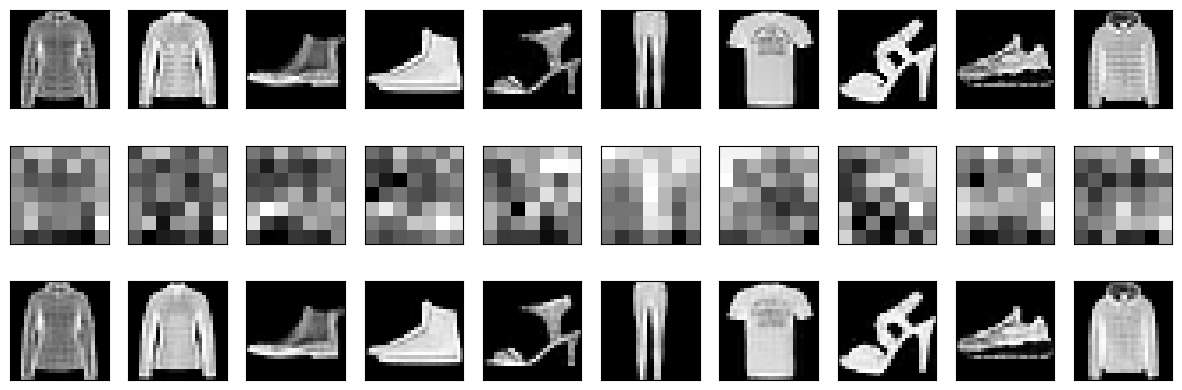

In [21]:
test_dataset = test_dataset.take(1)

output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.arange(10)

conv_output_samples = np.array(output_samples[idxs])

encoded = convolutional_encoder_model.predict(conv_output_samples)

predicted = convolutional_model.predict(conv_output_samples)

display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))

In [22]:
encoded.shape, predicted.shape

((10, 7, 7, 1), (10, 28, 28, 1))

## Denoising with a CNN Autoencoder

**Imports**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

**Prepare the Dataset**

In [ ]:
def map_image_with_noise(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  noise_factor = 0.5
  factor = noise_factor * tf.random.normal(shape=image.shape)
  image_noisy = image + factor
  image_noisy = tf.clip_by_value(image_noisy, 0.0, 1.0)

  return image_noisy, image

In [ ]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image_with_noise)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image_with_noise)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete6W0XTT/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete6W0XTT/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


**Build the Model**

In [ ]:
def encoder(inputs):
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2

In [ ]:
def bottle_neck(inputs):
  bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)

  return bottle_neck, encoder_visualization

In [ ]:
def decoder(inputs):
  conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

  return conv_3

In [ ]:
def convolutional_auto_encoder():
  inputs = tf.keras.layers.Input(shape=(28, 28, 1,))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)

  model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
  return model, encoder_model

In [ ]:
convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295168

**Compile and Train the Model**

In [ ]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=40)

Epoch 1/40
468/468 [==============================] - 28s 46ms/step - loss: 0.3194 - val_loss: 0.2997
Epoch 2/40
468/468 [==============================] - 16s 33ms/step - loss: 0.2948 - val_loss: 0.2943
Epoch 3/40
468/468 [==============================] - 16s 34ms/step - loss: 0.2906 - val_loss: 0.2909
Epoch 4/40
468/468 [==============================] - 12s 27ms/step - loss: 0.2878 - val_loss: 0.2894
Epoch 5/40
468/468 [==============================] - 13s 27ms/step - loss: 0.2861 - val_loss: 0.2878
Epoch 6/40
468/468 [==============================] - 13s 27ms/step - loss: 0.2850 - val_loss: 0.2865
Epoch 7/40
468/468 [==============================] - 13s 28ms/step - loss: 0.2842 - val_loss: 0.2860
Epoch 8/40
468/468 [==============================] - 13s 28ms/step - loss: 0.2831 - val_loss: 0.2852
Epoch 9/40
468/468 [==============================] - 13s 27ms/step - loss: 0.2826 - val_loss: 0.2844
Epoch 10/40
468/468 [==============================] - 14s 30ms/step - loss: 0.282

**Display sample results**

In [ ]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  for idx, noisy_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    noisy_image = np.reshape(noisy_image, shape)
    plt.imshow(noisy_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0)
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20)

1/1 [==============================] - 1s 1s/step


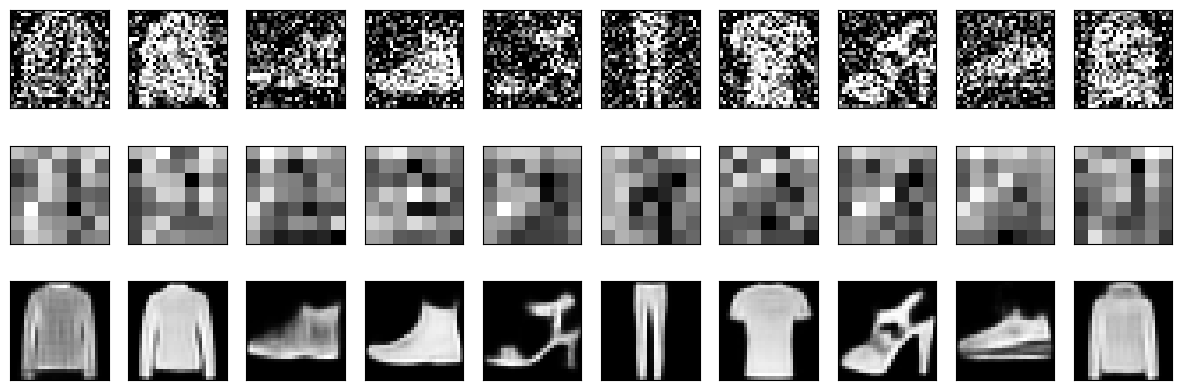

In [ ]:
test_dataset = test_dataset.take(1)

output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.arange(10)

conv_output_samples = np.array(output_samples[idxs])

encoded = convolutional_encoder_model.predict(conv_output_samples)

predicted = convolutional_model.predict(conv_output_samples, verbose=0)

display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))